In [7]:
import os
print(os.getcwd())
dir='../제12회 산업부 공모전 공공데이터'

C:\Users\bigdata09\Desktop\안태환_백업자료


In [2]:
!pip install ../패키지_파이썬/lightgbm-3.3.5-py3-none-win_amd64.whl

Processing c:\users\bigdata09\desktop\패키지_파이썬\lightgbm-3.3.5-py3-none-win_amd64.whl
lightgbm is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [3]:
! pip install ../패키지_파이썬/xgboost-1.7.5-py3-none-win_amd64.whl

Processing c:\users\bigdata09\desktop\패키지_파이썬\xgboost-1.7.5-py3-none-win_amd64.whl
xgboost is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [4]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus']=False

import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score


In [118]:
eleDf=pd.DataFrame()
for i in range(3):
    eleDf=pd.concat([eleDf,pd.read_csv(f'{dir}/A0{i}01~A0{i+1}00.csv')])
eleDf.reset_index(drop=True,inplace=True)
print("전력데이터 로드 완료")

전력데이터 로드 완료


In [69]:
print("결측치 확인",df.isna().sum())

결측치 확인 구분                     0
검침일                    0
순방향 유효전력량(KWH)    241692
정전여부                   0
dtype: int64


In [112]:
weatherDf=pd.read_csv('./강남AWS기상데이터.csv')
print("기상데이터 로드 완료")
popDf=pd.read_csv('./2021~2023_강남구_시간대별_생활인구_주성분.csv')
print("인구주성분 데이터 로드 완료")

기상데이터 로드 완료
인구주성분 데이터 로드 완료


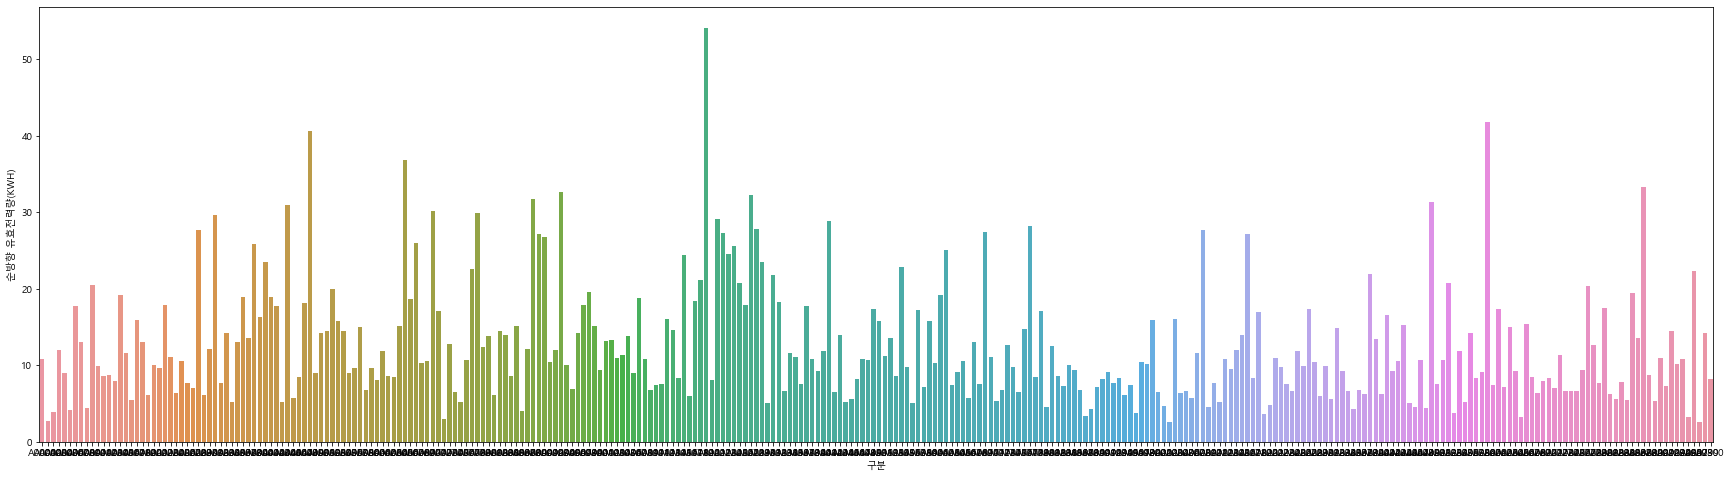

In [72]:
plt.figure(figsize=(30,8))
sns.barplot(data=df.groupby('구분')[['순방향 유효전력량(KWH)']].mean().reset_index(), x='구분', y='순방향 유효전력량(KWH)')
plt.title
plt.show()

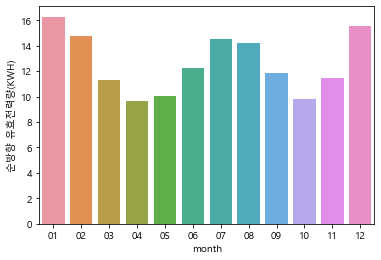

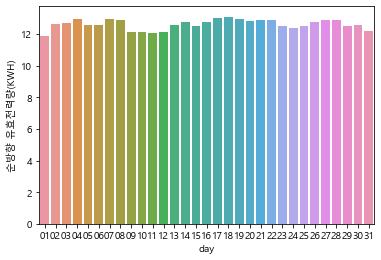

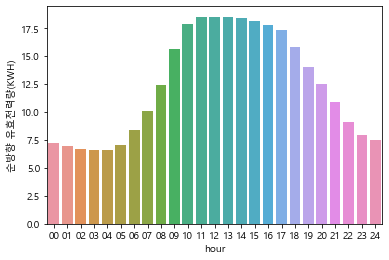

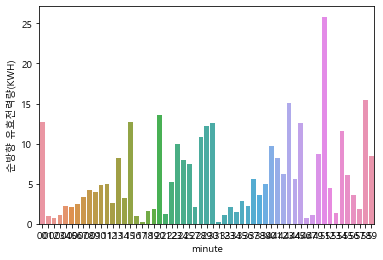

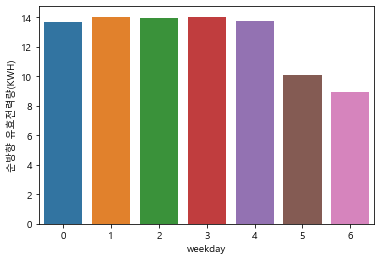

In [109]:
timeList=['month','day','hour','minute','weekday']
for k in timeList:
    edaDf=df.groupby(k)[['순방향 유효전력량(KWH)']].mean().reset_index()
    sns.barplot(data=edaDf,x=k,y='순방향 유효전력량(KWH)')
    plt.show()


# 0607방문

In [128]:
class prepareData:
    """전력데이터, 기상데이터, 인구(주성분)데이터를 입력받아 통합 데이터로 만들고, 시간관련 정보를 전처리하는 클래스"""
    def __init__(self,eleDf, weatherDf=None, popDf = None):
        self.eleDf = eleDf.rename(columns={'정전여부': 'isBlack'})
        self.weatherDf = weatherDf
        self.popDf = popDf
        self.idx=self.eleDf.index
        
        self.df=None
        self.mappingInfo={}
        
    def categorizeIsBlack(self):
        """정전여부를 라벨링"""
        self.eleDf['isBlack']=self.eleDf['isBlack'].apply(lambda x: 1 if x=='정전발생' else 0)
        
    def mergeDf(self):
        """eleDf와 선택에 따라서 기상데이터나 인구데이터를 통합하여 self.df에 저장하는 코드"""
        self.categorizeIsBlack()
        ele_copy=self.eleDf.copy()
        
        if self.weatherDf is None and self.popDf is None: # eleDf
            self.df=ele_copy
            
        elif self.weatherDf is not None and self.popDf is None: # eleDf+weatherDf
            weahter_copy=self.weatherDf.copy()
            weahter_copy['일시']=weahter_copy['일시'].apply(lambda x: x[:-3]) # weatherDf가 초단위 까지 표기되어있음(분단위로 머지해야함)
            self.df=ele_copy.merge(weahter_copy, how='left', left_on='검침일', right_on='일시').drop('일시',axis=1)
        
        elif self.weatherDf is None and self.popDf is not None: # eleDf+popDf
            pop_copy=self.popDf.copy()
            ele_copy['기준시점']=ele_copy['검침일'].apply(lambda x: x[:-3])
            pop_copy['기준시점']=pop_copy['기준시점'].apply(lambda x: x[:-6]) # poppcaDf가 초단위 까지 표기되어있음(시단위로 머지해야함)
            self.df=ele_copy.merge(pop_copy, how='left', left_on='기준시점', right_on='기준시점').drop(['기준시점','시간대구분','기준일ID'],axis=1)
            # 생활인구 데이터는 시간단위 이기 때문에 24:00 정보가 없으므로 앞의 값을 이용하여 결측치 채워주기
            
        elif self.weatherDf is not None and self.popDf is not None: # eleDf+weatherDf+popDf
            weahter_copy=self.weatherDf.copy()
            pop_copy=self.popDf.copy()
            weahter_copy['일시']=weahter_copy['일시'].apply(lambda x: x[:-3])
            ele_copy['기준시점']=ele_copy['검침일'].apply(lambda x: x[:-3])
            pop_copy['기준시점']=pop_copy['기준시점'].apply(lambda x: x[:-6])
            
            self.df=ele_copy.merge(weahter_copy, how='left', left_on='검침일', right_on='일시').merge(pop_copy, how='left', left_on='기준시점', right_on='기준시점').drop(['기준시점','시간대구분','기준일ID','일시'],axis=1)
    
    def fillNan(self):
        """기상 및 인구데이터와의 매핑 과정에서 발생한 결측치를 그 이전 값으로 대치(15분 단위로 끊기지 않는 분단위의 존재로 인하여 생겨난 NA들)"""
        naSr=self.df.isnull().sum()
        naCols=naSr[naSr!=0].index.drop('순방향 유효전력량(KWH)')
        self.df[naCols]=self.df[naCols].fillna(method='ffill')
    
    def generateTimeFeatures(self):
        """전력데이터에서 시계열 정보를 파생하는 코드"""
        def decomposeStrTime(datetimeStr, whichTime):
            if whichTime=='year':
                return datetimeStr[0:4]
            elif whichTime=='month':
                return datetimeStr[5:7]
            elif whichTime=='day':
                return datetimeStr[8:10]
            elif whichTime=='hour':
                return datetimeStr[-5:-3]
            elif whichTime=='minute':
                return datetimeStr[-2:]
            elif whichTime=='date':
                return datetimeStr[:10]
        self.df['year']=self.df['검침일'].apply(lambda x: decomposeStrTime(x,'year'))
        self.df['month']=self.df['검침일'].apply(lambda x: decomposeStrTime(x,'month'))
        self.df['day']=self.df['검침일'].apply(lambda x: decomposeStrTime(x,'day'))
        self.df['hour']=self.df['검침일'].apply(lambda x: decomposeStrTime(x,'hour'))
        self.df['minute']=self.df['검침일'].apply(lambda x: decomposeStrTime(x,'minute'))
        self.df['weekday']=pd.to_datetime(self.df['검침일'].apply(lambda x: decomposeStrTime(x,'date'))).apply(lambda x: x.weekday())

    def rankFeatureMapping(self):
        """고객,월,일,시간,요일 별로 평균 KWH가 높은 순서대로 높은 값을 부여하는 매핑"""
        mappingColumnList=['구분','month','day','hour','weekday']
        for mappingCol in mappingColumnList:
            mapping=self.df.groupby(mappingCol)['순방향 유효전력량(KWH)'].mean().rank().to_dict()
            self.df[mappingCol] = self.df[mappingCol].apply(lambda x: mapping[x])
            self.mappingInfo[mappingCol]=mapping

    def getDf(self):
        return self.df
    def getMappingInfo(self):
        return self.mappingInfo

In [129]:
p=prepareData(eleDf, weatherDf=weatherDf, popDf=popDf)
p.mergeDf()
p.fillNan()
p.generateTimeFeatures()
p.rankFeatureMapping()
df=p.getDf()
mp=p.getMappingInfo()

In [130]:
df.isnull().sum()

구분                     0
검침일                    0
순방향 유효전력량(KWH)    241692
isBlack                0
ta_mean                0
rn_sum                 0
ws_mean                0
hm_mean                0
강남구생활인구수_주성분           0
year                   0
month                  0
day                    0
hour                   0
minute                 0
weekday                0
dtype: int64

In [71]:
class transformData:
    """데이터프레임을 입력받아 데이터(X_train, X_val, y_train)로 분할하고, 스케일링을 적용하여 반환하는 함수"""
    def __init__(self,df,scalerName='RobustScaler'):
        self.df=df
        self.naIndex=None # 순방향 유효전력이 결측치인 행의 인덱스

        self.train=None
        self.val=None
        
        self.X_train=None
        self.X_val=None
        self.y_train=None
                
        self.scalerName=scalerName
        self.scaler=None

    def splitTrainVal(self):
        """훈련용 데이터와 검증용 데이터(최종결과물을 예측할 데이터) 분할"""
        naIndex=self.df[self.df['순방향 유효전력량(KWH)'].isna()].index
        self.naIndex=naIndex
        
        self.train = self.df.drop(self.naIndex)
        self.val = self.df.loc[self.naIndex]
    
    def splitXY(self, xColList, y="순방향 유효전력량(KWH)"):
        """예측에 사용될 컬럼을 입력받아 X와 y를 구분"""
        self.X_train= self.train[xColList]
        self.X_val=self.val[xColList]
        self.y_train=self.train[y]

    def scalingX(self):
        """훈련용 데이터, 검증용 데이터, 제출용 데이터를 스케일링"""
        if self.scalerName=="RobustScaler":
            from sklearn.preprocessing import RobustScaler
            self.scaler=RobustScaler()
        elif self.scalerName=="MinMaxScaler":
            from sklearn.preprocessing import MinMaxScaler
            self.scaler=MinMaxScaler()
        elif self.scalerName=="StandardScaler":
            from sklearn.preprocessing import StandardScaler
            self.scaler=StandardScaler()

        self.X_train=self.scaler.fit_transform(self.X_train)
        self.X_val=self.scaler.transform(self.X_val)

    def getTrainData(self):
        return self.X_train, self.y_train
    def getValData(self):
        return self.X_val
    def getScaler(self):
        return self.scaler

In [132]:
xColList=df.columns.drop(['검침일','순방향 유효전력량(KWH)'])
t=transformData(df,scalerName='RobustScaler')
t.splitTrainVal()
t.splitXY(xColList=xColList)
t.scalingX()
X_train, y_train = t.getTrainData()
X_val= t.getValData()

In [135]:
print("학습용 데이터 크기(X): ", X_train.shape)
print("학습용 데이터 크기(y): ", y_train.shape)

print("누락구간 사이즈: ", len(X_val))
print("사용된 X features: ", xColList)

학습용 데이터 크기(X):  (30806863, 13)
학습용 데이터 크기(y):  (30806863,)
누락구간 사이즈:  241692
사용된 X features:  Index(['구분', 'isBlack', 'ta_mean', 'rn_sum', 'ws_mean', 'hm_mean',
       '강남구생활인구수_주성분', 'year', 'month', 'day', 'hour', 'minute', 'weekday'],
      dtype='object')


In [142]:
class selectFeaturesLGBM:
    """LGBM을 이용하여 예측에 있어서의 중요도를 개략적으로 알아보고, 전력데이터만 사용할지 아니면 기상이나 인구데이터도 사용할지를 결정"""
    def __init__(self, X_train, y_train,xColList):
        self.X_train = X_train
        self.y_train = y_train
        from lightgbm import LGBMRegressor
        self.model = LGBMRegressor()
        
        self.cvResultDict=None
        self.colList=xColList
        
        
    def lgbmCv(self):
        from sklearn.model_selection import cross_validate, KFold
        self.cvResultDict = cross_validate(estimator=self.model, X=self.X_train, y=self.y_train, cv=KFold(n_splits=5, shuffle=True),
                                          scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'])
        self.model=self.model.fit(X_train,y_train)
        
    def getLGBMResults(self):
        return self.cvResultDict
    def getFeatureImportance(self):
        return pd.Series(self.model.feature_importances_, index=self.colList).sort_values(ascending=False)

In [ ]:
print(f"LGBM 교차검증 및 피쳐 중요도")
print(f"사용 컬럼: {xColList.tolist()}", end='\n\n')
lgbmFeat=selectFeaturesLGBM(X_train,y_train,xColList)
lgbmFeat.lgbmCv()
res=lgbmFeat.getLGBMResults()
print(res, end='\n\n')
imp=lgbmFeat.getFeatureImportance()
plt.figure(figsize=(6,8))
sns.barplot(x=imp.values, y=imp.index)
plt.show()

사용데이터별 및 스케일링 방법별 LGBM(default) 교차검증 결과 및 피쳐 중요도 확인
------------------------------------------------------------------------------------------------------------------------------------------------------
electrics_only
RobustScaler 사용
학습용 데이터 크기(X):  (30806863, 8)
학습용 데이터 크기(y):  (30806863,)
누락구간 사이즈:  241692
LGBM 교차검증 및 피쳐 중요도
사용 컬럼: ['구분', 'isBlack', 'year', 'month', 'day', 'hour', 'minute', 'weekday']

{'fit_time': array([21.98139691, 22.71736288, 21.9773984 , 22.76839042, 21.3093586 ]), 'score_time': array([3.96505857, 2.75507236, 2.68912005, 3.07717061, 2.68514633]), 'test_r2': array([0.7887797 , 0.78840589, 0.78803517, 0.78836904, 0.78950388]), 'test_neg_mean_absolute_error': array([-3.47090589, -3.48318545, -3.48018757, -3.48223511, -3.47495591]), 'test_neg_root_mean_squared_error': array([-5.383023  , -5.39198227, -5.39203371, -5.3913419 , -5.37483879])}



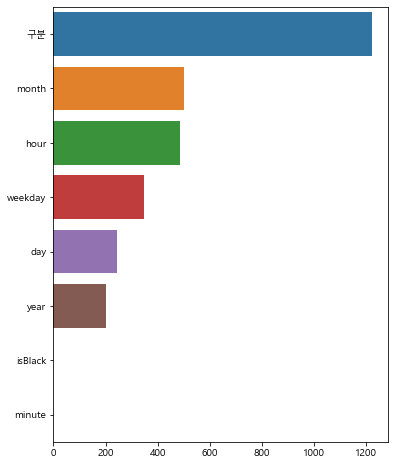

StandardScaler 사용
학습용 데이터 크기(X):  (30806863, 8)
학습용 데이터 크기(y):  (30806863,)
누락구간 사이즈:  241692
LGBM 교차검증 및 피쳐 중요도
사용 컬럼: ['구분', 'isBlack', 'year', 'month', 'day', 'hour', 'minute', 'weekday']

{'fit_time': array([22.73837972, 24.37249994, 21.71745682, 21.06740332, 21.11137533]), 'score_time': array([3.48508739, 3.20802498, 2.86011195, 2.97406363, 2.79310322]), 'test_r2': array([0.78893919, 0.78869871, 0.78892254, 0.78758372, 0.7895092 ]), 'test_neg_mean_absolute_error': array([-3.47484979, -3.47707191, -3.47467512, -3.48632744, -3.47634176]), 'test_neg_root_mean_squared_error': array([-5.37916388, -5.39250821, -5.38226355, -5.39549779, -5.37662324])}



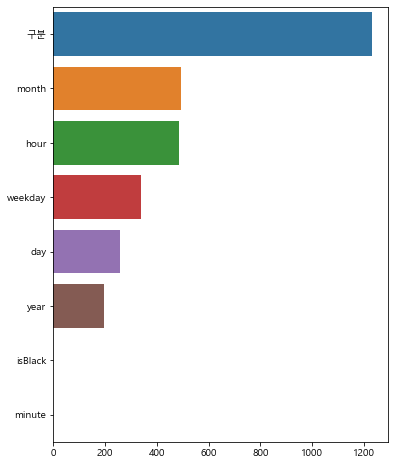

MinMaxScaler 사용
학습용 데이터 크기(X):  (30806863, 8)
학습용 데이터 크기(y):  (30806863,)
누락구간 사이즈:  241692
LGBM 교차검증 및 피쳐 중요도
사용 컬럼: ['구분', 'isBlack', 'year', 'month', 'day', 'hour', 'minute', 'weekday']

{'fit_time': array([21.13434744, 21.82337546, 22.19838595, 22.69337726, 20.7603302 ]), 'score_time': array([3.11213374, 2.94116879, 3.22423816, 3.27214122, 2.96413827]), 'test_r2': array([0.78856106, 0.78868747, 0.78806941, 0.78972854, 0.78972724]), 'test_neg_mean_absolute_error': array([-3.47823685, -3.47478882, -3.48145901, -3.47089419, -3.47057251]), 'test_neg_root_mean_squared_error': array([-5.38866825, -5.38710983, -5.3921291 , -5.37092292, -5.37296215])}



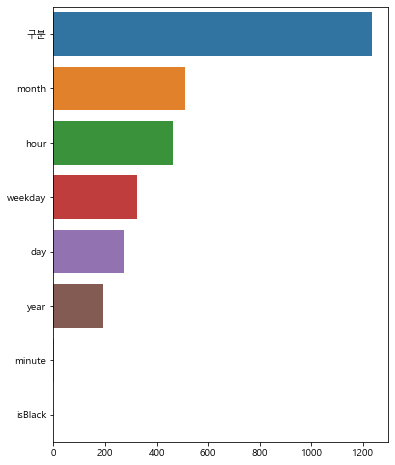

------------------------------------------------------------------------------------------------------------------------------------------------------
electrics+weather
RobustScaler 사용
학습용 데이터 크기(X):  (30806863, 12)
학습용 데이터 크기(y):  (30806863,)
누락구간 사이즈:  241692
LGBM 교차검증 및 피쳐 중요도
사용 컬럼: ['구분', 'isBlack', 'ta_mean', 'rn_sum', 'ws_mean', 'hm_mean', 'year', 'month', 'day', 'hour', 'minute', 'weekday']

{'fit_time': array([26.76450753, 29.57558274, 26.5104301 , 30.09351206, 28.04049969]), 'score_time': array([3.0740664 , 2.88706851, 2.89905477, 3.00917006, 2.8571198 ]), 'test_r2': array([0.79857719, 0.79959508, 0.80072596, 0.79907682, 0.8005904 ]), 'test_neg_mean_absolute_error': array([-3.40608535, -3.40071136, -3.39606024, -3.40559938, -3.39490399]), 'test_neg_root_mean_squared_error': array([-5.25905609, -5.24382065, -5.22906592, -5.25451153, -5.23041759])}



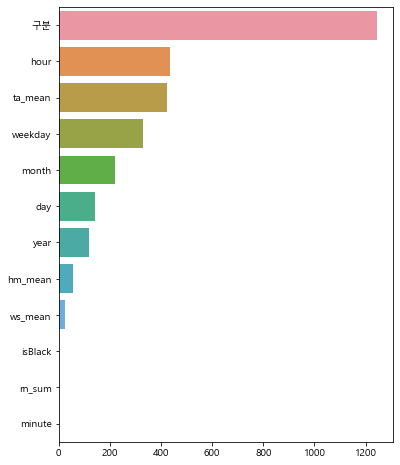

StandardScaler 사용
학습용 데이터 크기(X):  (30806863, 12)
학습용 데이터 크기(y):  (30806863,)
누락구간 사이즈:  241692
LGBM 교차검증 및 피쳐 중요도
사용 컬럼: ['구분', 'isBlack', 'ta_mean', 'rn_sum', 'ws_mean', 'hm_mean', 'year', 'month', 'day', 'hour', 'minute', 'weekday']

{'fit_time': array([30.74452305, 27.82046556, 27.17644906, 26.05542541, 27.55246782]), 'score_time': array([3.04812884, 3.41213155, 2.88512802, 2.97107863, 2.94611168]), 'test_r2': array([0.79987858, 0.79995236, 0.80052833, 0.79928136, 0.80024657]), 'test_neg_mean_absolute_error': array([-3.39648377, -3.39776613, -3.39825072, -3.40103489, -3.39854255]), 'test_neg_root_mean_squared_error': array([-5.24393762, -5.23755632, -5.23126999, -5.24847365, -5.2383575 ])}



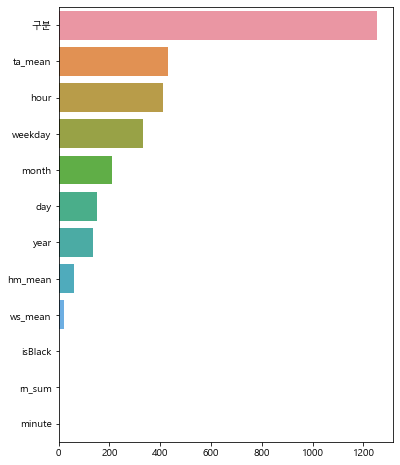

MinMaxScaler 사용
학습용 데이터 크기(X):  (30806863, 12)
학습용 데이터 크기(y):  (30806863,)
누락구간 사이즈:  241692
LGBM 교차검증 및 피쳐 중요도
사용 컬럼: ['구분', 'isBlack', 'ta_mean', 'rn_sum', 'ws_mean', 'hm_mean', 'year', 'month', 'day', 'hour', 'minute', 'weekday']

{'fit_time': array([26.64542699, 26.81045532, 28.41249657, 26.91045475, 25.94042587]), 'score_time': array([3.27808952, 3.66312122, 2.96410322, 3.01011705, 2.98712873]), 'test_r2': array([0.79947373, 0.80196267, 0.79987261, 0.80309404, 0.79983636]), 'test_neg_mean_absolute_error': array([-3.39999771, -3.38860743, -3.40194364, -3.3782459 , -3.39515089]), 'test_neg_root_mean_squared_error': array([-5.24200531, -5.21223507, -5.24409242, -5.2018562 , -5.24216115])}



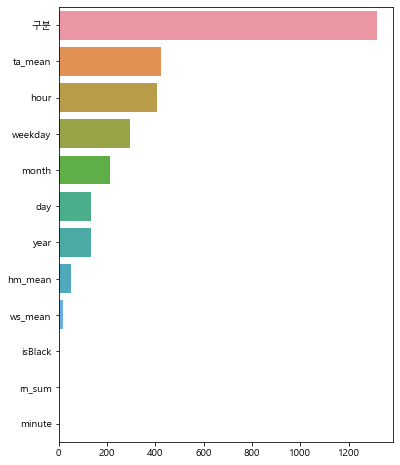

------------------------------------------------------------------------------------------------------------------------------------------------------
electrics+population
RobustScaler 사용
학습용 데이터 크기(X):  (30806863, 9)
학습용 데이터 크기(y):  (30806863,)
누락구간 사이즈:  241692
LGBM 교차검증 및 피쳐 중요도
사용 컬럼: ['구분', 'isBlack', '강남구생활인구수_주성분', 'year', 'month', 'day', 'hour', 'minute', 'weekday']

{'fit_time': array([23.06036854, 23.05137348, 23.46936321, 25.72536325, 24.70934916]), 'score_time': array([4.11414361, 3.85013628, 3.42814684, 3.52816796, 3.61014295]), 'test_r2': array([0.80238841, 0.80419915, 0.80338534, 0.80265805, 0.80367992]), 'test_neg_mean_absolute_error': array([-3.38431944, -3.36895622, -3.37222412, -3.38627572, -3.37493894]), 'test_neg_root_mean_squared_error': array([-5.20926324, -5.18770612, -5.18870955, -5.20645364, -5.19142014])}



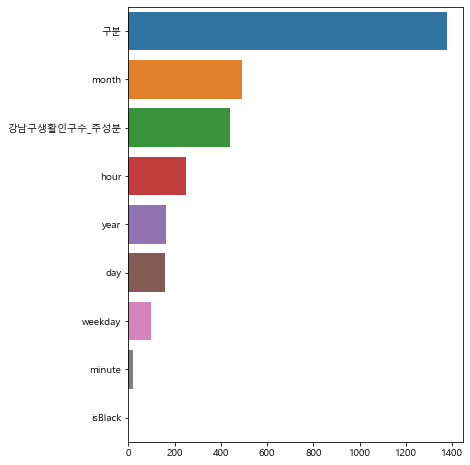

StandardScaler 사용
학습용 데이터 크기(X):  (30806863, 9)
학습용 데이터 크기(y):  (30806863,)
누락구간 사이즈:  241692
LGBM 교차검증 및 피쳐 중요도
사용 컬럼: ['구분', 'isBlack', '강남구생활인구수_주성분', 'year', 'month', 'day', 'hour', 'minute', 'weekday']

{'fit_time': array([23.53935504, 24.3323245 , 23.24035096, 24.25345349, 23.5493753 ]), 'score_time': array([3.93714643, 3.48308992, 3.88614798, 3.66211963, 3.60311556]), 'test_r2': array([0.80250658, 0.80405331, 0.80303062, 0.80572308, 0.80356229]), 'test_neg_mean_absolute_error': array([-3.38165501, -3.37214631, -3.37599749, -3.36455238, -3.37010369]), 'test_neg_root_mean_squared_error': array([-5.20924086, -5.18199823, -5.19830838, -5.16471737, -5.19533416])}



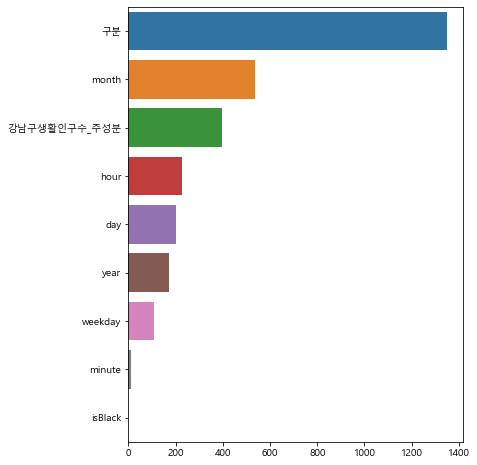

MinMaxScaler 사용
학습용 데이터 크기(X):  (30806863, 9)
학습용 데이터 크기(y):  (30806863,)
누락구간 사이즈:  241692
LGBM 교차검증 및 피쳐 중요도
사용 컬럼: ['구분', 'isBlack', '강남구생활인구수_주성분', 'year', 'month', 'day', 'hour', 'minute', 'weekday']

{'fit_time': array([23.13541937, 22.54131913, 22.7204988 , 22.58134365, 23.01635408]), 'score_time': array([3.77409625, 3.56707382, 4.49399805, 3.59313917, 4.65715313]), 'test_r2': array([0.80552589, 0.80596019, 0.80600858, 0.80554619, 0.80499661]), 'test_neg_mean_absolute_error': array([-3.36172566, -3.36013524, -3.35966586, -3.35977918, -3.36233199]), 'test_neg_root_mean_squared_error': array([-5.16749147, -5.16185791, -5.15485993, -5.17081234, -5.17322342])}



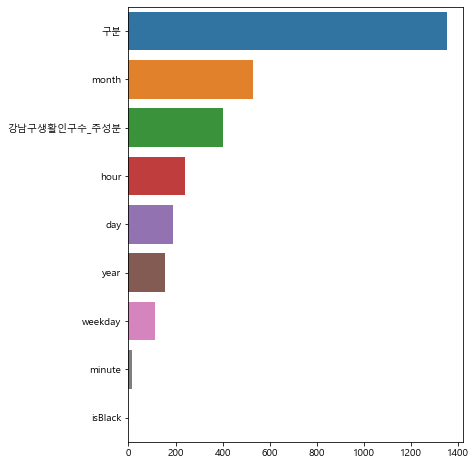

------------------------------------------------------------------------------------------------------------------------------------------------------
electrics+weather+population
RobustScaler 사용
학습용 데이터 크기(X):  (30806863, 13)
학습용 데이터 크기(y):  (30806863,)
누락구간 사이즈:  241692
LGBM 교차검증 및 피쳐 중요도
사용 컬럼: ['구분', 'isBlack', 'ta_mean', 'rn_sum', 'ws_mean', 'hm_mean', '강남구생활인구수_주성분', 'year', 'month', 'day', 'hour', 'minute', 'weekday']

{'fit_time': array([27.80143023, 29.06645274, 29.72348213, 29.88851953, 28.47344756]), 'score_time': array([3.42905569, 3.96814489, 3.74417233, 3.1821301 , 3.87418771]), 'test_r2': array([0.81571253, 0.81399001, 0.81525762, 0.81431259, 0.81567355]), 'test_neg_mean_absolute_error': array([-3.28190403, -3.29166731, -3.28815205, -3.29161532, -3.2839793 ]), 'test_neg_root_mean_squared_error': array([-5.03157102, -5.05084115, -5.03666957, -5.05038883, -5.02776721])}



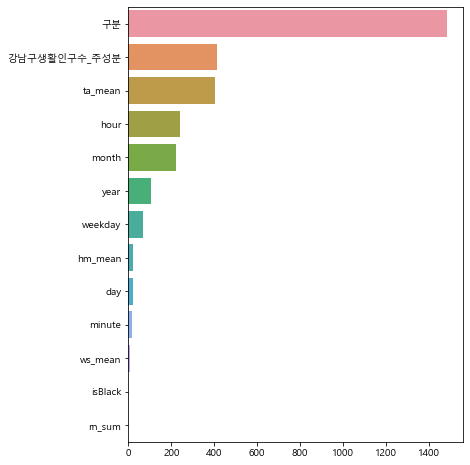

StandardScaler 사용
학습용 데이터 크기(X):  (30806863, 13)
학습용 데이터 크기(y):  (30806863,)
누락구간 사이즈:  241692
LGBM 교차검증 및 피쳐 중요도
사용 컬럼: ['구분', 'isBlack', 'ta_mean', 'rn_sum', 'ws_mean', 'hm_mean', '강남구생활인구수_주성분', 'year', 'month', 'day', 'hour', 'minute', 'weekday']

{'fit_time': array([28.55651402, 28.86044526, 28.42951417, 29.5544548 , 29.61845946]), 'score_time': array([3.67603326, 4.17012715, 3.24710655, 3.16004014, 3.7121346 ]), 'test_r2': array([0.81357632, 0.81642533, 0.81478231, 0.81542931, 0.816606  ]), 'test_neg_mean_absolute_error': array([-3.29327985, -3.28198653, -3.29043929, -3.28428801, -3.28046981]), 'test_neg_root_mean_squared_error': array([-5.05836716, -5.02147766, -5.03855994, -5.03572359, -5.01750997])}



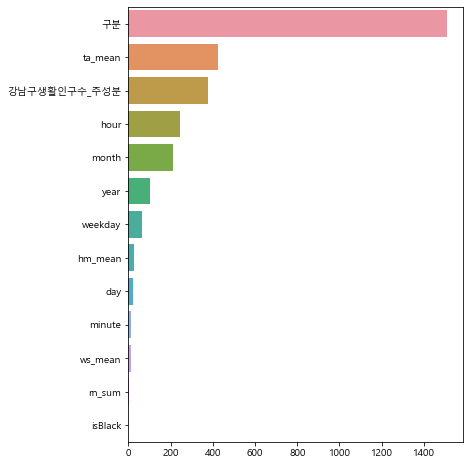

MinMaxScaler 사용
학습용 데이터 크기(X):  (30806863, 13)
학습용 데이터 크기(y):  (30806863,)
누락구간 사이즈:  241692
LGBM 교차검증 및 피쳐 중요도
사용 컬럼: ['구분', 'isBlack', 'ta_mean', 'rn_sum', 'ws_mean', 'hm_mean', '강남구생활인구수_주성분', 'year', 'month', 'day', 'hour', 'minute', 'weekday']

{'fit_time': array([28.99342632, 27.94443226, 28.45945454, 31.45048594, 28.09250808]), 'score_time': array([3.13714695, 3.18213105, 4.05516338, 3.59305954, 3.80414724]), 'test_r2': array([0.81654895, 0.81650564, 0.81559885, 0.81292399, 0.81496395]), 'test_neg_mean_absolute_error': array([-3.27972037, -3.28264656, -3.28556704, -3.29845674, -3.28398272]), 'test_neg_root_mean_squared_error': array([-5.01837685, -5.019248  , -5.03320024, -5.06606939, -5.03848389])}



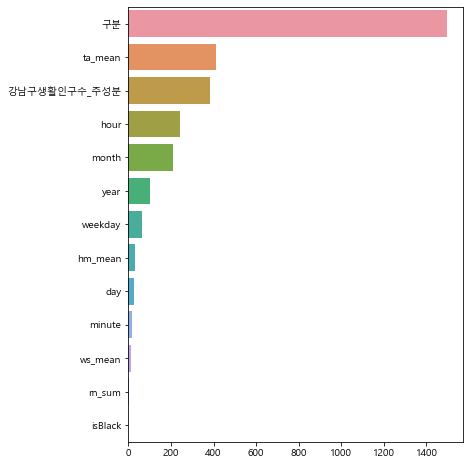

In [150]:
dataDict={
    'electrics_only': [None,None],
    'electrics+weather': [weatherDf,None],
    'electrics+population': [None, popDf],
    'electrics+weather+population': [weatherDf,popDf]
}
print("사용데이터별 및 스케일링 방법별 LGBM(default) 교차검증 결과 및 피쳐 중요도 확인")
for k, v in dataDict.items():
    print("-"*150)
    print(k, end='\n')
    p=prepareData(eleDf, weatherDf=v[0], popDf=v[1])
    p.mergeDf()
    p.fillNan()
    p.generateTimeFeatures()
    p.rankFeatureMapping()
    df=p.getDf()
    mp=p.getMappingInfo()
    xColList=df.columns.drop(['검침일','순방향 유효전력량(KWH)'])
    
    for scalerStr in ['RobustScaler','StandardScaler','MinMaxScaler']:
        print(f'{scalerStr} 사용', end='\n')
        t=transformData(df,scalerName=scalerStr)
        t.splitTrainVal()
        t.splitXY(xColList=xColList)
        t.scalingX()
        X_train, y_train = t.getTrainData()
        X_val= t.getValData()

        print("학습용 데이터 크기(X): ", X_train.shape)
        print("학습용 데이터 크기(y): ", y_train.shape)
        print("누락구간 사이즈: ", len(X_val))

        print(f"LGBM 교차검증 및 피쳐 중요도")
        print(f"사용 컬럼: {xColList.tolist()}", end='\n\n')
        lgbmFeat=selectFeaturesLGBM(X_train,y_train,xColList)
        lgbmFeat.lgbmCv()
        res=lgbmFeat.getLGBMResults()
        print(res, end='\n\n')
        imp=lgbmFeat.getFeatureImportance()
        plt.figure(figsize=(6,8))
        sns.barplot(x=imp.values, y=imp.index)
        plt.show()


In [110]:
class selectModel:
    """회귀 모델의 성능을 비교하여 가장 좋은 MAE를 갖는 모델을 선정하고 최적화를 진행하는 클래스"""
    def __init__(self, modelDict, X_train, y_train):
        self.modelDict=modelDict # {모델명: 모델객체,...}

        self.X_train, self.y_train = X_train, y_train
        
        self.cvResultDict={}

        self.bestModel=None

    def defaultModelling(self):
        """파라미터 튜닝 없이 기본 모델을 사용하였을 경우의 모델별 성능을 비교하여 교차검증 5회 score를 cvResultDict에 넣고
        , y_val 검증 결과 score를 testResultDict에 저장"""
        from sklearn.model_selection import cross_validate, KFold
        for modelName, modelObj in self.modelDict.items():
            print(f'*******************************{modelName} Start!*******************************')
            cvResult=cross_validate(estimator=modelObj, X=self.X_train, y=self.y_train, cv=KFold(n_splits=5, shuffle=True),
                          verbose=1, scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'])
            self.cvResultDict[modelName]=cvResult
            print(f'{modelName}의 5회 교차검증 점수: {self.cvResultDict[modelName]}', end='\n\n')
            
    def getCvResults(self):
        return self.cvResultDict

In [111]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

regressors = {
    'LinearRegressor': LinearRegression(),
#     "DecisionTreeRegressor": DecisionTreeRegressor(),
    "LGBMRegressor": LGBMRegressor(),
#     "XGBRegressor": XGBRegressor(),
#     "XGBRFRegressor": XGBRFRegressor(),
#     "RandomForestRegressor": RandomForestRegressor(n_estimators=7),
#     "BaggingRegressor": BaggingRegressor(),
#     "AdaBoostRegressor": AdaBoostRegressor(),
#     "GradientBoostingRegressor": GradientBoostingRegressor(),
#     "GaussianNB": GaussianNB(),
#     "MLPRegressor": MLPRegressor(),
#     "KNeighborsRegressor": KNeighborsRegressor(),
#     "SVR": SVR()
}

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score

s=selectModel(modelDict=regressors, X_train=X_train, y_train=y_train, scoring=r2_score)
s.defaultModelling()
cvScores=s.getCvResults()

*******************************LGBMRegressor Start!*******************************


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LGBMRegressor의 5회 교차검증 점수: {'fit_time': array([24.16160846, 23.62764001, 24.8906548 , 22.53759956, 24.17960334]), 'score_time': array([3.61208439, 3.50109935, 3.39712286, 3.32014608, 3.14111137]), 'test_r2': array([0.78843132, 0.78747958, 0.79054245, 0.78940962, 0.78793627]), 'test_neg_mean_absolute_error': array([-3.48169962, -3.48362785, -3.46502571, -3.47542217, -3.47642719]), 'test_neg_root_mean_squared_error': array([-5.38940867, -5.39847996, -5.36589567, -5.37835755, -5.3919763 ])}

*******************************XGBRegressor Start!*******************************


KeyboardInterrupt: 

In [105]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei